<a href="https://colab.research.google.com/github/mdominguezd/PyTorch_Training/blob/main/Transform_Ready_To_Use_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install geemap -q
!pip install pycrs -q
!pip install geedim -q
!pip install torchgeo -q

In [ ]:
!wget -O Planet.zip https://www.dropbox.com/scl/fi/nnicm1ubuo0whdwjnb4f2/Planet.zip?rlkey=vton9ccmuz2hvhcx6zfuewc7u&dl=0

In [134]:
import ee
import geemap
import os
import numpy as np
import geopandas as gpd
from zipfile import ZipFile
import torchvision.transforms as T
from skimage import io
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
with ZipFile("Planet.zip", 'r') as zipped:
    zipped.extractall(path="./")

In [96]:
patch_size = 512

overlap = patch_size // 2

conversion = T.ToTensor()

image_ids = [1,3,5]
img_folder = 'Planet'

imgs = []

for img_index in image_ids:
  print("Working on image " + str(img_index))
  #Load the tile and the corresponding ground truth.
  img = io.imread(os.path.join(img_folder, "PlanetTilesTanzania_" + '{:04d}'.format(img_index) + '.tif')).astype(np.float32)

  img = img/np.max(img) # Normalize all bands to a random value

  #Crop into patches, following a regularly sampled grid.
  #i and j are defined as the center of the patch to crop.
  for i in np.arange(patch_size//2, img.shape[0] - patch_size // 2, overlap):
    for j in np.arange(patch_size//2, img.shape[1] - patch_size // 2, overlap):
      #Crop the image and the ground truth into patch around (i,j) and save
      #them in self.imgs and self.GTs arrays.
      #For the image, note that we are taking the three channels (using ":")
      #for the 3rd dimension, and we do the conversion to tensor.
      im_patch = img[i - patch_size//2:i + patch_size // 2, j - patch_size // 2:j + patch_size // 2,:]
      imgs.append(conversion(im_patch))


Working on image 1
Working on image 3
Working on image 5


In [101]:
imgs[0][:3].permute(1,2,0)[:,:,2]

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.1947, 0.2008, 0.2086],
        [0.0000, 0.0000, 0.0000,  ..., 0.1967, 0.2006, 0.2045],
        [0.0000, 0.0000, 0.0000,  ..., 0.1950, 0.1978, 0.2003],
        ...,
        [0.3174, 0.2968, 0.2706,  ..., 0.2865, 0.2837, 0.2868],
        [0.3428, 0.3319, 0.3194,  ..., 0.3004, 0.3060, 0.3066],
        [0.3501, 0.3445, 0.3372,  ..., 0.3063, 0.3174, 0.3180]])

In [118]:
imgs[0][:3].shape

torch.Size([3, 512, 512])

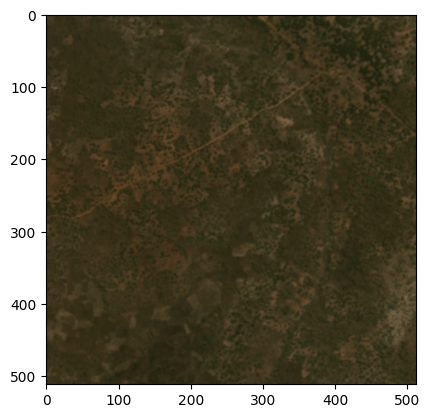

In [131]:
plt.imshow(imgs[2][:3].flip([-3]).permute(1,2,0))

In [138]:
class Tanzania_Dataset(Dataset):
  def __init__(self, img_folder, image_ids, patch_size=512): #GT_folder
    self.imgs = []
    # self.GTs = []

    overlap = patch_size // 2

    conversion = T.ToTensor()

    # image_ids = [1,3,5]
    img_folder = 'Planet'

    for img_index in image_ids:
      print("Working on image " + str(img_index))
      #Load the tile and the corresponding ground truth.
      img = io.imread(os.path.join(img_folder, "PlanetTilesTanzania_" + '{:04d}'.format(img_index) + '.tif')).astype(np.float32)

      img = img/np.max(img) # Normalize all bands to a random value

      #Crop into patches, following a regularly sampled grid.
      #i and j are defined as the center of the patch to crop.
      for i in np.arange(patch_size//2, img.shape[0] - patch_size // 2, overlap):
        for j in np.arange(patch_size//2, img.shape[1] - patch_size // 2, overlap):
          #Crop the image and the ground truth into patch around (i,j) and save
          #them in self.imgs and self.GTs arrays.
          #For the image, note that we are taking the three channels (using ":")
          #for the 3rd dimension, and we do the conversion to tensor.
          im_patch = img[i - patch_size//2:i + patch_size // 2, j - patch_size // 2:j + patch_size // 2,:]
          self.imgs.append(conversion(im_patch))

  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, idx):
    #__getitem__ asks for the sample number idx. Since we pre-loaded the images
    #and the ground truths, we just have to return the corresponding sample.
    img = self.imgs[idx].float()
    # GT = self.GTs[idx]

    #We also need to return the ground truth as a tensor
    return img

In [140]:
tnz_DS = Tanzania_Dataset('Planet',[1,2,3,4,5,6,7])

Working on image 1
Working on image 2
Working on image 3
Working on image 4
Working on image 5
Working on image 6
Working on image 7


In [142]:
tnz_DS.__getitem__(5).shape

torch.Size([4, 512, 512])